# Sample Composition Analysis: Microbiome vs Spirulina vs Mouse

In [1]:
#Boilerplate Import 
import sys
sys.path.append('..')
import os
from itertools import chain
from collections import defaultdict
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scripts import utils
from scripts.analysis import build_loci

In [2]:
# Load data
BASE = '../data'

metadata = pd.read_csv(os.path.join(BASE,"filt_metadata.csv"), index_col=0)
samp_names = list(metadata.index)

unenr_grouped_loci = utils.load(os.path.join(BASE,"unenriched_grouped_loci.pkl.gz"))
enr_grouped_loci = utils.load(os.path.join(BASE,"enriched_grouped_loci.pkl.gz"))
grouped_loci = utils.load(os.path.join(BASE,"grouped_loci.pkl.gz"))

In [3]:
sample_pairs = metadata.reset_index().set_index(['enriched', 'technical']).sort_index().groupby(level=[0,1])

pairs = []
for x, y in sample_pairs:
    pairs.append(list(y['index'].values))
sample_names = list(chain(*pairs))

n14_samps = [x[0] for x in pairs]
n15_samps = [x[1] for x in pairs]

n14_un_samps = [x for x in n14_samps if x.startswith('UL_')]
n15_un_samps = [x for x in n15_samps if x.startswith('UL_')]

n14_enr_samps = [x for x in n14_samps if x.startswith('CL_')]
n15_enr_samps = [x for x in n15_samps if x.startswith('CL_')]

In [4]:
def get_count_prots(quant, samps):
    out = dict()
    for samp in samps:
        if samp in quant.keys():
            out[samp] = quant[samp]['counts']
        else:
            out[samp] = np.nan
    return out

In [5]:
def count_only_dict(grouped_loci, samps):
    prots = []
    for prot in grouped_loci:
        protd = {'id': prot.cluster_id,
                'name': prot.name,
                'lca': prot.lca,
                'lca_organism': prot.lca_organism,
                'gene': build_loci.get_gene_name(prot.name),
                'genus': build_loci.get_genus(prot.name),
                'spir': any(['Arthrospira' in inf['d'] for inf in prot.prot_info])}
        protd.update(get_count_prots(prot.quantification, samps))
        prots.append(protd)
    return prots

In [6]:
dat = pd.DataFrame(count_only_dict(grouped_loci, samp_names))

In [7]:
dat.head()

,CL_Mix_1120_1,CL_Mix_1120_N_1,CL_Mix_Pool_1,CL_Mix_Pool_2,CL_Mix_Pool_3,CL_Mix_Pool_4,CL_Mix_Pool_5,CL_Mix_Pool_N_1,CL_Mix_Pool_N_2,CL_Mix_Pool_N_3,...,UL_Mix_1121_N_4,UL_Mix_Pool_1,UL_Mix_Pool_N_1,gene,genus,id,lca,lca_organism,name,spir
0,NaN,NaN,4.0,4.0,3.0,4.0,5.0,0.0,NaN,0.0,...,NaN,20.0,0.0,,,58957830,NaN,,1B-dyr7-07_GL0001150_1_306_+,False
1,24.0,0.0,25.0,16.0,8.0,27.0,11.0,0.0,0.0,0.0,...,0.0,18.0,0.0,,,167845895,NaN,,54_GL0084505_1_1202_+,False
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,,,166862854,NaN,,23_GL0106182_1_1235_+,False
3,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,...,NaN,NaN,NaN,,,166248459,NaN,,MC-6-5_GL0039211_1_684_+,False
4,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,,,166158349,NaN,,7-1_GL0083136_1_516_+,False


In [8]:
summary = dat[samp_names].replace(0, np.nan).count().to_frame()
summary = summary.rename(columns={0: "total_clust"})
summary['clust_with_raito'] =  dat[samp_names].count()

In [9]:
summary['total_counts'] = dat[samp_names].sum()
summary['mouse_clust'] = dat.query('lca == 10090 or genus == "Mus"')[samp_names].replace(0, np.nan).count()
summary['spir_clust'] = dat.query("genus == 'Arthrospira' or lca in [35823, 1150, 118562] or spir == True")[samp_names].replace(0, np.nan).count()
summary['mouse_counts'] = dat.query('lca == 10090 or genus == "Mus"')[samp_names].sum()
summary['spir_counts'] = dat.query("genus == 'Arthrospira' or lca in [35823, 1150, 118562] or spir == True")[samp_names].sum()

summary['mouse_ratio_c'] = summary['mouse_counts'] / summary['total_counts']
summary['spir_ratio_c'] = summary['spir_counts'] / summary['total_counts']
summary['remain_c'] = 1 - summary['mouse_ratio_c'] - summary['spir_ratio_c']
summary['spir_ratio_l'] = summary['spir_clust'] / summary['total_clust']
summary['mouse_ratio_l'] = summary['mouse_clust'] / summary['total_clust']
summary['remain_l'] = 1 - summary['mouse_ratio_l'] - summary['spir_ratio_l']

In [10]:
summary

,total_clust,clust_with_raito,total_counts,mouse_clust,spir_clust,mouse_counts,spir_counts,mouse_ratio_c,spir_ratio_c,remain_c,spir_ratio_l,mouse_ratio_l,remain_l
UL_Mix_1111_1,613,829,22588.0,105,37,10388.0,3589.0,0.459890,0.158890,0.381220,0.060359,0.171289,0.768352
UL_Mix_1111_2,883,1138,22409.0,129,40,9582.0,3864.0,0.427596,0.172431,0.399973,0.045300,0.146093,0.808607
UL_Mix_1111_3,754,1011,25784.0,100,33,10311.0,4628.0,0.399899,0.179491,0.420610,0.043767,0.132626,0.823607
UL_Mix_1121_1,1430,1613,28337.0,112,32,8915.0,2091.0,0.314606,0.073790,0.611603,0.022378,0.078322,0.899301
UL_Mix_1121_2,1216,1343,31966.0,119,30,10347.0,2474.0,0.323688,0.077395,0.598918,0.024671,0.097862,0.877467
UL_Mix_1121_3,867,995,27463.0,97,20,8830.0,1627.0,0.321524,0.059243,0.619233,0.023068,0.111880,0.865052
UL_Mix_1121_4,656,798,18099.0,87,19,7859.0,1786.0,0.434223,0.098679,0.467098,0.028963,0.132622,0.838415
UL_Mix_Pool_1,1779,1840,39569.0,92,20,8410.0,1533.0,0.212540,0.038742,0.748717,0.011242,0.051714,0.937043
UL_Mix_1111_N_1,480,749,13803.0,47,49,2450.0,6674.0,0.177498,0.483518,0.338984,0.102083,0.097917,0.800000
UL_Mix_1111_N_2,681,1035,15854.0,61,57,2136.0,7124.0,0.134729,0.449350,0.415920,0.083700,0.089574,0.826725


In [11]:
tech_rep = dict()
for i, s in enumerate(n14_un_samps):
    tech_rep.update({s:"{}".format(i+1)})
for i, s in enumerate(n15_un_samps):
    tech_rep.update({s:"{}".format(i+1)})
for i, s in enumerate(n14_enr_samps):
    tech_rep.update({s:"{}".format(i+1)})
for i, s in enumerate(n15_enr_samps):
    tech_rep.update({s:"{}".format(i+1)})

In [12]:
def plot_stacked_bar(smps, title, df):

    sns.set_style('white')
    df = df.loc[smps]
    X = np.arange(len(df))
    
    p1 = plt.bar(X, df['mouse_ratio_c'])
    p2 = plt.bar(X, df['spir_ratio_c'], bottom = df['mouse_ratio_c'], color = sns.color_palette()[1])
    p3 = plt.bar(X, df['remain_c'], bottom = df['mouse_ratio_c']+df['spir_ratio_c'], color = sns.color_palette()[2])
    plt.xticks(X + .8/2., [tech_rep[s] for s in smps])
    plt.ylabel('Fraction of Spectral Counts')
    plt.xlabel('Technical Replicate')
    plt.legend([p3[0], p2[0], p1[0]],['Microbiome', 'Spirulina', 'Mouse'], frameon=True)
    plt.title(title)


## Spec count sources over technical replicates

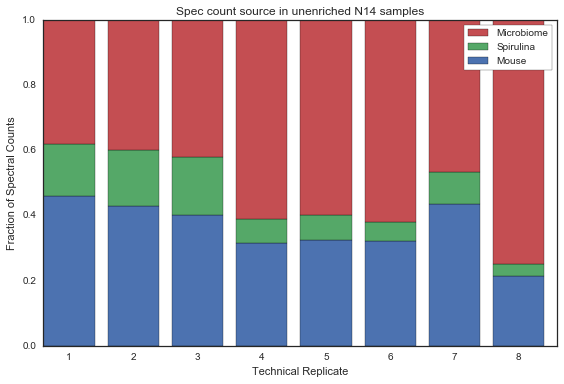

In [13]:
import warnings
warnings.filterwarnings('ignore')

plot_stacked_bar(n14_un_samps, "Spec count source in unenriched N14 samples", summary)

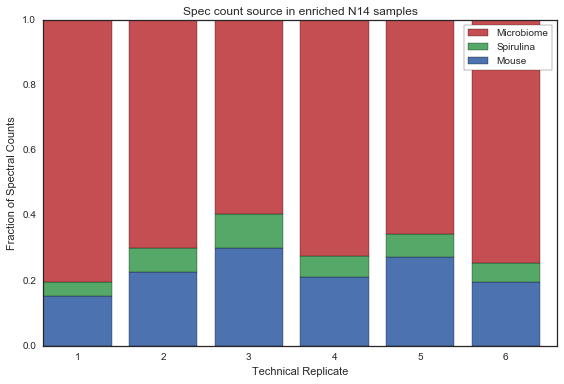

In [14]:
plot_stacked_bar(n14_enr_samps, "Spec count source in enriched N14 samples", summary)

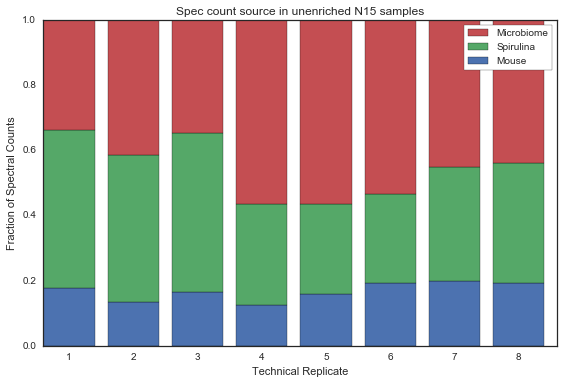

In [15]:
plot_stacked_bar(n15_un_samps, "Spec count source in unenriched N15 samples", summary)

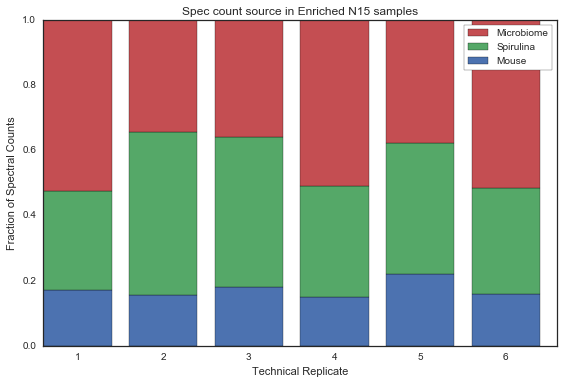

In [16]:
plot_stacked_bar(n15_enr_samps, "Spec count source in Enriched N15 samples", summary)

In [17]:
def plot_locus_bar(smps, title, df):

    sns.set_style('white')
    df = df.loc[smps]
    X = np.arange(len(df))
    
    p1 = plt.bar(X, df['mouse_ratio_l'])
    p2 = plt.bar(X, df['spir_ratio_l'], bottom = df['mouse_ratio_l'], color = sns.color_palette()[1])
    p3 = plt.bar(X, df['remain_l'], bottom = df['mouse_ratio_l']+df['spir_ratio_l'], color = sns.color_palette()[2])
    plt.xticks(X + .8/2., [tech_rep[s] for s in smps])
    plt.ylabel('Fraction of Identified Loci')
    plt.xlabel('Technical Replicate')
    plt.legend([p3[0], p2[0], p1[0]],['Microbiome', 'Spirulina', 'Mouse'], frameon=True)
    plt.title(title)

## Loci Sources across technical replicates

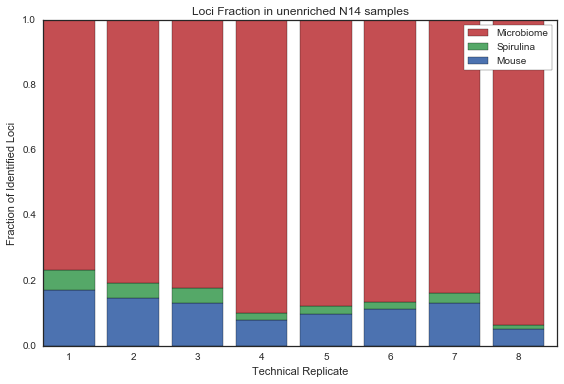

In [18]:
plot_locus_bar(n14_un_samps, 'Loci Fraction in unenriched N14 samples', summary)

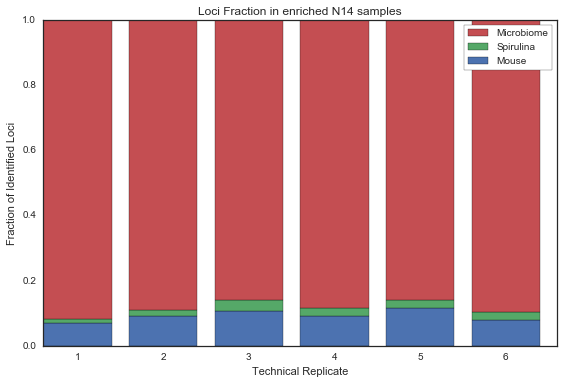

In [19]:
plot_locus_bar(n14_enr_samps, 'Loci Fraction in enriched N14 samples', summary)

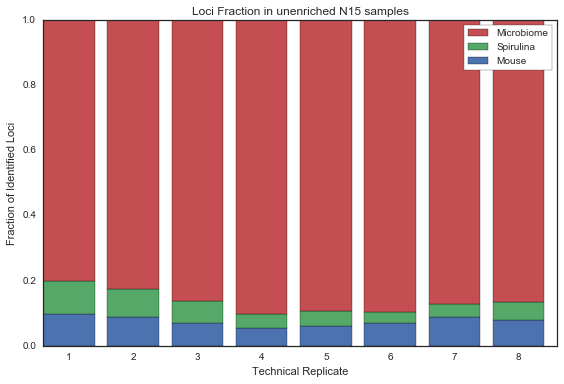

In [20]:
plot_locus_bar(n15_un_samps, 'Loci Fraction in unenriched N15 samples', summary)

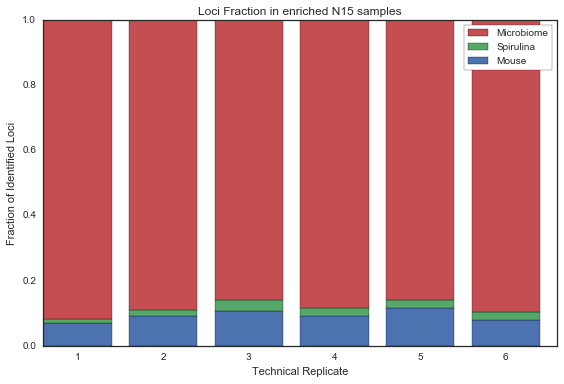

In [21]:
plot_locus_bar(n14_enr_samps, 'Loci Fraction in enriched N15 samples', summary)

In [22]:
n14_un_avg = summary.loc[n14_un_samps].mean().to_frame().rename(columns={0:'n14_un_avg'})
n15_un_avg = summary.loc[n15_un_samps].mean().to_frame().rename(columns={0:'n15_un_avg'})
n14_enr_avg = summary.loc[n14_enr_samps].mean().to_frame().rename(columns={0:'n14_enr_avg'})
n15_enr_avg = summary.loc[n15_enr_samps].mean().to_frame().rename(columns={0:'n15_enr_avg'})

In [23]:
avg_counts = pd.concat([n14_un_avg, n14_enr_avg, n15_un_avg, n15_enr_avg], axis = 1).T

In [24]:
avg_counts

,total_clust,clust_with_raito,total_counts,mouse_clust,spir_clust,mouse_counts,spir_counts,mouse_ratio_c,spir_ratio_c,remain_c,spir_ratio_l,mouse_ratio_l,remain_l
n14_un_avg,1024.750000,1195.875000,27026.875000,105.125000,28.875,9330.250000,2699.00,0.361746,0.107333,0.530922,0.032468,0.115301,0.852231
n14_enr_avg,1203.833333,1239.666667,25801.166667,106.666667,26.000,5651.333333,1727.00,0.225987,0.069059,0.704954,0.023096,0.092526,0.884378
n15_un_avg,705.125000,1066.500000,16760.250000,52.000000,39.500,2763.750000,6153.25,0.167683,0.375242,0.457075,0.058517,0.076599,0.864884
n15_enr_avg,334.333333,984.666667,4776.166667,27.500000,26.000,812.833333,1939.50,0.172846,0.388278,0.438876,0.082874,0.087664,0.829462


In [25]:
tech_rep = {'n14_un_avg': "N14 Unenriched", "n15_un_avg": "N15 Unenrichd", "n14_enr_avg": "N14 Enriched", 'n15_enr_avg': "N15 Enriched"}

In [26]:
type_keys = sorted(list(tech_rep.keys()), key = lambda x: (x.split("_")[0], len(x.split('_')[1])) )

## Sources of Loci/Spec counts averaged across techincal reps

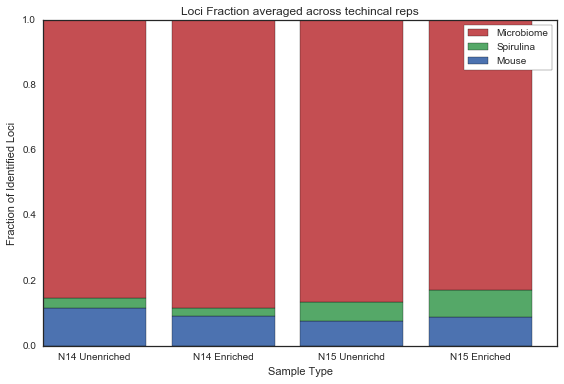

In [27]:
plot_locus_bar(type_keys, 'Loci Fraction averaged across techincal reps', avg_counts)
plt.xlabel("Sample Type");

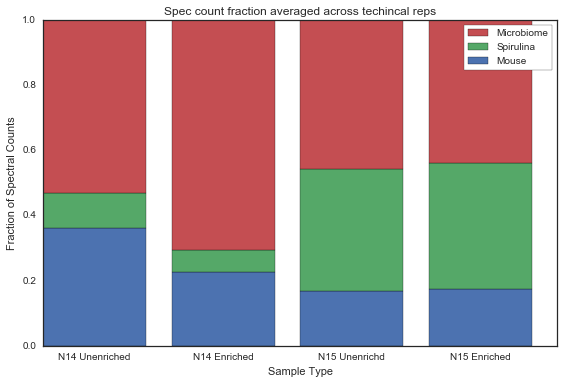

In [28]:
plot_stacked_bar(type_keys, 'Spec count fraction averaged across techincal reps', avg_counts)
plt.xlabel("Sample Type");

In [29]:
uner_sig = build_loci.get_sig_df(unenr_grouped_loci)

In [30]:
enr_sig = build_loci.get_sig_df(enr_grouped_loci)

In [31]:
dat = dict()
for locus in grouped_loci:
    if locus.p_value < .05 and abs(locus.avg_ratio) > 4:
        dat[i] = {'p_value': locus.p_value, 'avg_ratio': locus.avg_ratio, 'name': locus.name, 'id':locus.cluster_id,
                  'lca': locus.lca, 'lca_organism': locus.lca_organism, 'gene': build_loci.get_gene_name(locus.name),
                  'genus': build_loci.get_genus(locus.name), 'spir': any(['Arthrospira' in inf['d'] for inf in locus.prot_info]),
                  'logfc': np.log2(locus.avg_ratio)}

In [32]:
uner_sig_up_ids = uner_sig.query('passes and logfc > 0')['id'].tolist()
uner_sig_down_ids = uner_sig.query('passes and logfc < 0')['id'].tolist()

enr_sig_up_ids = enr_sig.query('passes and logfc > 0')['id'].tolist()
enr_sig_down_ids = enr_sig.query('passes and logfc < 0')['id'].tolist()

In [33]:
def count_only_dict1(grouped_loci, samps, sig_list):
    prots = []
    for prot in grouped_loci:
        if prot.cluster_id in sig_list:
            protd = {'id': prot.cluster_id,
                    'name': prot.name,
                    'lca': prot.lca,
                    'lca_organism': prot.lca_organism,
                    'gene': build_loci.get_gene_name(prot.name),
                    'genus': build_loci.get_genus(prot.name),
                    'spir': any(['Arthrospira' in inf['d'] for inf in prot.prot_info])}
            protd.update(get_count_prots(prot.quantification, samps))
            prots.append(protd)
    return prots

In [34]:
def dat_to_summary(dat, samp_names):
    summary = dat[samp_names].replace(0, np.nan).count().to_frame()
    summary = summary.rename(columns={0: "total_clust"})
    summary['clust_with_raito'] =  dat[samp_names].count()
    
    summary['total_counts'] = dat[samp_names].sum()
    summary['mouse_clust'] = dat.query('lca == 10090 or genus == "Mus"')[samp_names].replace(0, np.nan).count()
    summary['spir_clust'] = dat.query("genus == 'Arthrospira' or lca in [35823, 1150, 118562] or spir == True")[samp_names].replace(0, np.nan).count()
    summary['mouse_counts'] = dat.query('lca == 10090 or genus == "Mus"')[samp_names].sum()
    summary['spir_counts'] = dat.query("genus == 'Arthrospira' or lca in [35823, 1150, 118562] or spir == True")[samp_names].sum()

    summary['mouse_ratio_c'] = summary['mouse_counts'] / summary['total_counts']
    summary['spir_ratio_c'] = summary['spir_counts'] / summary['total_counts']
    summary['remain_c'] = 1 - summary['mouse_ratio_c'] - summary['spir_ratio_c']
    summary['spir_ratio_l'] = summary['spir_clust'] / summary['total_clust']
    summary['mouse_ratio_l'] = summary['mouse_clust'] / summary['total_clust']
    summary['remain_l'] = 1 - summary['mouse_ratio_l'] - summary['spir_ratio_l']
    
    return summary

In [35]:
unenr_keys = n14_un_samps+n15_un_samps
enr_keys = n14_enr_samps+n15_enr_samps

dat1 = pd.DataFrame(count_only_dict1(grouped_loci, unenr_keys, uner_sig_up_ids))
sum1 = dat_to_summary(dat1, unenr_keys)
unenr_up = sum1.loc[unenr_keys].mean().to_frame().rename(columns={0:'unenr_up'})

dat1 = pd.DataFrame(count_only_dict1(grouped_loci, unenr_keys, uner_sig_down_ids))
sum1 = dat_to_summary(dat1, unenr_keys)
unenr_down = sum1.loc[unenr_keys].mean().to_frame().rename(columns={0:'unenr_down'})

dat1 = pd.DataFrame(count_only_dict1(grouped_loci, enr_keys, enr_sig_up_ids))
sum1 = dat_to_summary(dat1, enr_keys)
enr_up = sum1.loc[enr_keys].mean().to_frame().rename(columns={0:'enr_up'})

dat1 = pd.DataFrame(count_only_dict1(grouped_loci, enr_keys, enr_sig_down_ids))
sum1 = dat_to_summary(dat1, enr_keys)
enr_down = sum1.loc[enr_keys].mean().to_frame().rename(columns={0:'enr_down'})

In [36]:
enr_df = pd.concat([unenr_up, unenr_down, enr_up, enr_down], axis = 1).T

In [37]:
enr_df

,total_clust,clust_with_raito,total_counts,mouse_clust,spir_clust,mouse_counts,spir_counts,mouse_ratio_c,spir_ratio_c,remain_c,spir_ratio_l,mouse_ratio_l,remain_l
unenr_up,35.000000,57.375000,2242.437500,11.875000,0.687500,1319.500000,17.571429,0.654682,0.006058,0.326529,0.034398,0.404773,0.560829
unenr_down,32.000000,45.812500,2363.625000,2.062500,11.312500,223.000000,1560.250000,0.111669,0.644615,0.243716,0.391518,0.075932,0.532550
enr_up,17.333333,27.916667,804.500000,4.750000,0.583333,271.083333,70.583333,0.229421,0.077860,0.692718,0.043074,0.193131,0.763794
enr_down,11.250000,14.833333,223.416667,1.583333,4.666667,50.166667,120.750000,0.258383,0.492782,0.248835,0.406194,0.160736,0.433070


In [38]:
tech_rep = {'unenr_up': "Unenriched Upregulated in Tcell", 'unenr_down': "Unenriched Downregulated in Tcell", 
        "enr_up": "Enriched Up in Tcell", "enr_down": "Enriched Down in Tcell"}

types = sorted(list(tech_rep.keys()), key=lambda x: (x.split('_')[1], x.split('_')[0]), reverse = True)

## Spec count/Locus sources only in significantly different samples

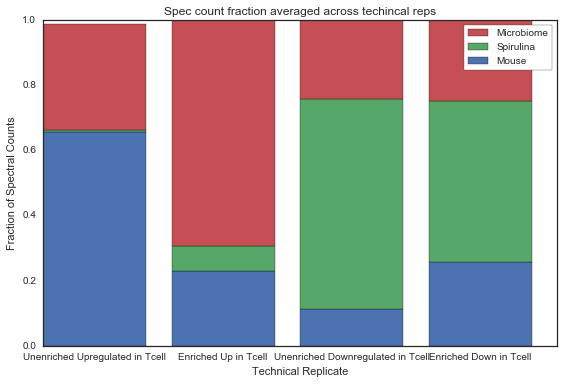

In [39]:
plot_stacked_bar(types, 'Spec count fraction averaged across techincal reps', enr_df)

Maybe you're getting a bit more microbiome proteins by spec count when you're enriching?

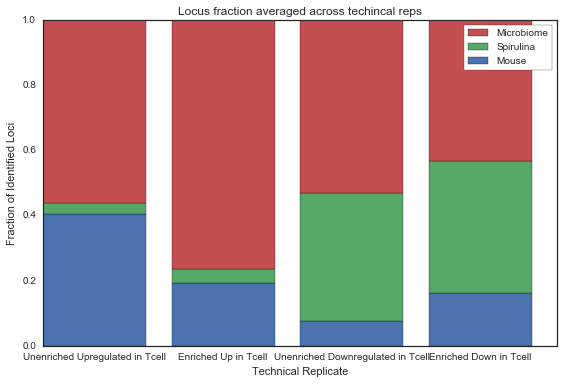

In [40]:
plot_locus_bar(types, 'Locus fraction averaged across techincal reps', enr_df)

Doesn't look like enrichment does much at all in affecting the number of loci identified